# SVI and Surface SVI functions

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad

from svi import *

In [7]:
%matplotlib inline

## Let's read and transform real data from a volatility surface

In [2]:
vol = pd.read_csv("iv.csv").filter(["period", "moneyness", "iv"])  # Select cols
vol = vol[vol["period"] == 30]  # Subset rows where period = 30
vol["tau"] = vol["period"] / 365  # Creates a new column named tau
vol.rename(columns={"moneyness": "k"}, inplace=True)  # rename column to k
vol["w"] = vol["iv"]**2 * vol["tau"]
vol.head()  # Show some rows

,period,k,iv,tau,w
0,30,0.033012,0.088965,0.082192,0.000651
1,30,0.026784,0.089044,0.082192,0.000652
2,30,0.022096,0.090193,0.082192,0.000669
3,30,0.018021,0.091416,0.082192,0.000687
4,30,0.014473,0.093857,0.082192,0.000724


## Keep variables out of data frame just for ease of use

In [3]:
k = vol["k"]
w = vol["w"]
iv = vol["iv"]
tau = vol["tau"]
weight = 1.
grid = 5

## Numerical simulation example as in [prof. Jacquier](http://wwwf.imperial.ac.uk/~ajacquie/)

In [5]:
a, b, rho, m, sigma = 0.030358, 0.0503815, -0.1, 0.3, 0.048922
sviParams = [a, b, rho, m, sigma]
sviParams2 = [a, b, rho, m, 3. * sigma]
xx = np.linspace(-1., 1., 100)
impliedVar = np.sqrt(raw_svi(sviParams, xx))
impliedVarpp = np.sqrt(raw_svi(sviParams2, xx))
# Testing RMSE
rmse(w, k, sviParams)

0.046347100961708063

## Ploting two SVI parametrizations

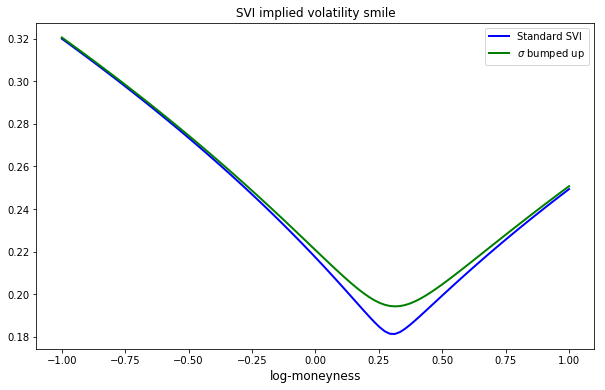

In [9]:
plt.figure(figsize=(10, 6))  # make separate figure
plt.plot(xx, impliedVar, 'b', linewidth=2, label="Standard SVI")
plt.plot(xx, impliedVarpp, 'g', linewidth=2, label="$\sigma$ bumped up")
plt.title("SVI implied volatility smile")
plt.xlabel("log-moneyness", fontsize=12)
plt.legend()

## Now let's plot the densities associated

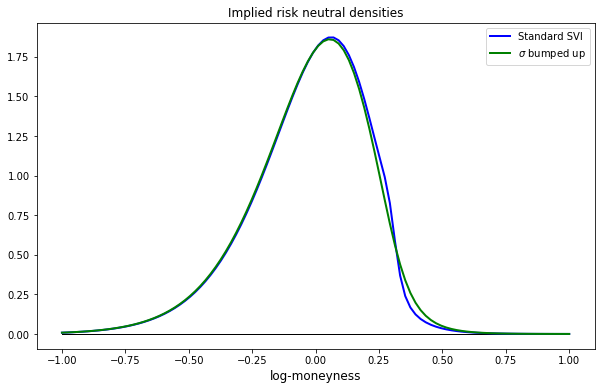

In [10]:
dens1 = density(sviParams, xx)
dens2 = density(sviParams2, xx)
zero = np.linspace(0.0, 0.0, 100)

plt.figure(figsize=(10, 6))
plt.plot(xx, zero, 'k', linewidth=1)
plt.plot(xx, dens1, 'b', linewidth=2, label="Standard SVI")
plt.plot(xx, dens2, 'g', linewidth=2, label="$\sigma$ bumped up")
plt.title("Implied risk neutral densities")
plt.xlabel("log-moneyness", fontsize=12)
plt.legend()

## Check that density integrates to one

In [11]:
print("Area under denstiy is:",
      quad(lambda x: density(sviParams, x), xx[0], xx[-1])[0])

Area under denstiy is: 0.9988985223420257


# Calibration of a slice

Let's make two direct calibrations (no quasi-explicit reparametrization). One with brute force global optimization and a refinement with a simplex algorith, and the second through a differential evolution - DE, optimization refined by a L-BFGS-B method.

In [12]:
# Fits a slice through direct brute force
pbrute = svi_fit_direct(k, w, weight, "brute", grid)
ivbrute = np.sqrt(raw_svi(pbrute[0], k)/tau)
# Fits a slice through direct Differential Evolution - DE
pDE = svi_fit_direct(k, w, weight, "DE", grid)
ivDE = np.sqrt(raw_svi(pDE.x, k)/tau)

## Data frame comparison

In [36]:
parameters = ["a", "b", "$\\rho$", "m", "$\sigma$", "Obj. Value"]
table = pd.DataFrame({"Pars": parameters,
                      "brute": np.append(pbrute[0], pbrute[1]),
                      "DE": np.append(pDE.x, pDE.fun)})
table[["Pars", "brute", "DE"]]

,Pars,brute,DE
0,a,2.328877e-04,1.592129e-07
1,b,1.594218e-02,1.951059e-02
2,$\rho$,-9.004230e-01,-7.957616e-01
3,m,-3.307131e-03,-7.307587e-03
4,$\sigma$,-4.390930e-02,5.027313e-02
5,Obj. Value,2.966233e-10,7.512824e-11


In [37]:
table.dtypes

DE       float64
Pars      object
brute    float64
dtype: object

We see that the objective value from DE's calibration is lower, thus, we should expect a better fit of DE to real data. Let's check it in a plot.

## Plot of smiles

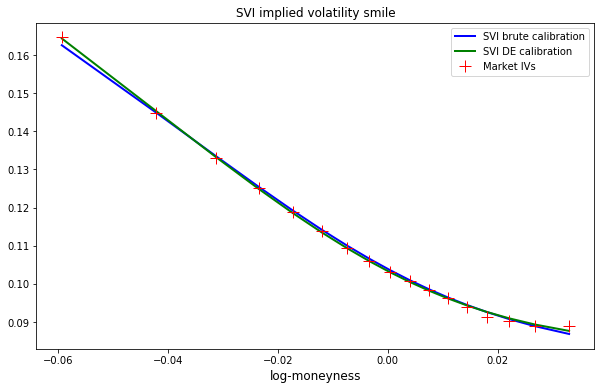

In [34]:
plt.figure(figsize=(10, 6))  # make separate figure
plt.plot(k, ivbrute, 'b', linewidth=2, label="SVI brute calibration")
plt.plot(k, ivDE, 'g', linewidth=2, label="SVI DE calibration")
plt.plot(k, iv, 'r+', markersize=12, label="Market IVs")
plt.title("SVI implied volatility smile")
plt.xlabel("log-moneyness", fontsize=12)
plt.legend()